# Bloco 2

<p align="justify">
Este trabalho é referente as tarefas desenvolvidas no Bloco 2. Espera-se desenvolver um projeto capaz de utilizar os comandos aprendidos pela linguagem de programação Python, na disciplina de Aprendizado de Máquina, além de desenvolver um sistema de previsão através de Machine Learning. O grupo desenvolvedor é composto pelas discentes:
<ul><p align="justify"><li>
Isabela Bento Beneti </p></li>
<p align="justify"><li>
Monyque Karoline de Paula Silva </p></li>
<p align="justify"><li>
Sofia Baccega C.C. de Oliveira </p></li>
<p align="justify"><li>
Sophia Figueiredo Michel </p></li>
</ul><hr>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree, utils, preprocessing
from itertools import product
from matplotlib import pyplot as plt

In [2]:
#Dados do Cerrado Brasileiro, armazenados mensalmente via .csv
arquivos = ['janeiro_2021.csv','fevereiro_2021.csv','março_2021.csv','abril_2021.csv','maio_2021.csv','junho_2021.csv','julho_2021.csv','agosto_2021.csv','setembro_2021.csv','outubro_2021.csv','novembro_2021.csv','dezembro_2021.csv','janeiro.csv','fevereiro.csv','marco.csv','abril.csv','maio.csv','junho.csv','julho.csv','agosto.csv','setembro.csv','outubro.csv','novembro.csv']

In [3]:
def read_csv(list_of_files):
    dfs = []
    for x in list_of_files:
        file = pd.read_csv(x, sep=',')
        dfs.append(file)
    df = pd.concat(dfs).reset_index(drop=True)
        
    return df

In [4]:
meses = read_csv(arquivos)
#print(meses)

In [5]:
#Dados trabalhados para a eliminação de NaN nas colunas e identificação dos tipos de dados
meses.convert_dtypes()
meses.dropna(how='any', inplace=True)

In [6]:
## Para rodar o código pela primeira vez, descomente essas linhas
meses.drop(columns=['estado', 'municipio', 'pais', 'bioma'], axis = 1, inplace=True)

In [7]:
meses['satelite']= meses['datahora']
meses['satelite'] = meses['satelite'].str[11:13] #criando coluna "hora" a partir de "data_hora_gmt"
meses['datahora'] = meses['datahora'].str[5:7] #criando coluna "mes" a partir de "data_hora_gmt"
meses_fogo = meses['riscofogo'] > 0
meses = meses[meses_fogo]
meses.rename(columns={'satelite': 'hora'}, inplace= True)
meses.rename(columns={'datahora': 'mes'}, inplace = True)
meses.describe

<bound method NDFrame.describe of         mes hora  diasemchuva  precipitacao  riscofogo  latitude  longitude  \
0        01   16          6.0          0.00       0.70 -13.15300  -45.51600   
1        01   16       -999.0          0.10       0.80  -2.73600  -42.20700   
2        01   16          6.0          2.10       0.90 -14.35500  -45.87300   
4        01   16          7.0          0.20       0.90 -12.87100  -44.84700   
6        01   17          0.0          0.20       0.20 -12.74193  -51.44371   
...      ..  ...          ...           ...        ...       ...        ...   
2997483  11   23         12.0          4.65       0.91 -21.07830  -48.40050   
2997484  11   23         11.0          4.06       0.98 -21.09900  -48.39570   
2997487  11   23          2.0          0.40       0.04  -9.69610  -44.58670   
2997488  11   23         12.0          4.65       0.91 -21.07830  -48.40050   
2997489  11   23         11.0          4.06       0.98 -21.09900  -48.39570   

           frp  


In [8]:
meses = meses.reset_index()
del meses['index']
display(meses)

,mes,hora,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,01,16,6.0,0.00,0.70,-13.15300,-45.51600,65.1
1,01,16,-999.0,0.10,0.80,-2.73600,-42.20700,15.5
2,01,16,6.0,2.10,0.90,-14.35500,-45.87300,51.0
3,01,16,7.0,0.20,0.90,-12.87100,-44.84700,30.3
4,01,17,0.0,0.20,0.20,-12.74193,-51.44371,3.6
...,...,...,...,...,...,...,...,...
2232513,11,23,12.0,4.65,0.91,-21.07830,-48.40050,103.5
2232514,11,23,11.0,4.06,0.98,-21.09900,-48.39570,124.2
2232515,11,23,2.0,0.40,0.04,-9.69610,-44.58670,71.7
2232516,11,23,12.0,4.65,0.91,-21.07830,-48.40050,103.1


In [9]:
meses["mes"] = meses["mes"].astype(float)
meses["hora"] = meses["hora"].astype(float)
print(meses.dtypes)

mes             float64
hora            float64
diasemchuva     float64
precipitacao    float64
riscofogo       float64
latitude        float64
longitude       float64
frp             float64
dtype: object


<hr>

## DEFINIÇÕES DE TREINO E TESTE - PARAMETRIZAÇÕES

In [61]:
TAMANHO_TESTE = 0.1 # fração de dados utilizada para teste: 10%
SEMENTE_ALEATORIA = 61455 # semente escolhida aleatoriamente
DATASET_NAME = 'meses'
FEATURES = ['mes','hora','diasemchuva', 'precipitacao', 'latitude', 'longitude']
TARGET = ['riscofogo']

meses = meses.dropna()
#print(meses)

indices = meses.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

meses_treino = meses.loc[indices_treino]
meses_teste = meses.loc[indices_teste]

print(meses_treino.reindex(FEATURES, axis=1))

X_treino = meses_treino.reindex(FEATURES, axis=1).values
y_treino = meses_treino.reindex(TARGET, axis=1).values
X_teste = meses_teste.reindex(FEATURES, axis=1).values
y_teste = meses_teste.reindex(TARGET, axis=1).values
print(X_treino)
print(y_treino)

          mes  hora  diasemchuva  precipitacao  latitude  longitude
1054411  11.0  16.0          7.0           1.5  -3.42869  -43.78965
36626     5.0   5.0         17.0           0.0 -13.85058  -59.71609
275219    8.0  17.0         15.0           0.0 -21.18307  -47.69699
815300    9.0  15.0        102.0           4.7  -9.04778  -45.16346
1027621  10.0   5.0          7.0           1.5  -5.90700  -46.64620
...       ...   ...          ...           ...       ...        ...
465073    8.0   3.0         11.0           0.0  -6.35697  -46.74086
12691     2.0  18.0          3.0           0.0 -21.43759  -57.29801
317948    8.0  16.0         60.0           0.0  -6.87879  -45.69300
977822   10.0   4.0         12.0           0.0  -9.81791  -44.84449
1406577   8.0   3.0         76.0           0.0 -10.71973  -44.90229

[2009266 rows x 6 columns]
[[ 11.       16.        7.        1.5      -3.42869 -43.78965]
 [  5.        5.       17.        0.      -13.85058 -59.71609]
 [  8.       17.       15.    

<hr>

### TREINO DE MODELOS NORMALIZADOS:

In [11]:
#Normalização
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

MinMaxScaler()

## 1. Baseline

In [12]:
# Criar  o modelo
modelo_baseline = DummyRegressor()
# Treinar o modelo
modelo_baseline.fit(normalizador_x.transform(X_treino),normalizador_y.transform(y_treino))

# Realiza uma previsão usando o modelo treinado
previsao = modelo_baseline.predict(normalizador_x.transform(X_treino))
print(previsao)

[0.90639803 0.90639803 0.90639803 ... 0.90639803 0.90639803 0.90639803]


In [13]:
#Análise do RMSE
y_verdadeiro = y_teste
y_previsao = modelo_baseline.predict(normalizador_x.transform(X_teste))

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo baseline foi de {RMSE}")

O RMSE do modelo baseline foi de 0.22437296840498952


**ANÁLISE DOS RESULTADOS OBTIDOS**

Este modelo realiza a média de todos os valores normalizados do modelo, apresentando uma resolução com eficiência baixa, a qual possui 0.22 de erro de predição.

### MODELO DE PREVISÃO

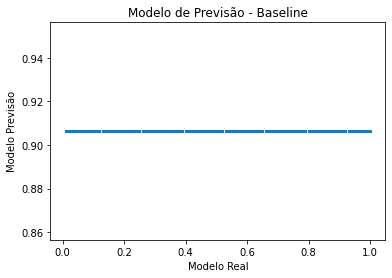

In [14]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - Baseline")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**ANÁLISE DOS RESULTADOS OBTIDOS**

Este modelo realiza a média de todos os valores normalizados do modelo, apresentando uma resolução com eficiência baixa, a qual possui 0.22 de erro de predição.

## 2. K-vizinhos mais próximos

In [15]:
# cria o modelo
modelo_knm = KNeighborsRegressor()

# treina o modelo
modelo_knm.fit(normalizador_x.transform(X_treino),normalizador_y.transform(y_treino))

# realiza uma previsão usando o modelo treinado
previsao = modelo_knm.predict(normalizador_x.transform(X_treino))
previsao = normalizador_y.inverse_transform(previsao)
print(previsao)

[[0.16]
 [0.2 ]
 [1.  ]
 ...
 [1.  ]
 [1.  ]
 [1.  ]]


Hiperparâmetros - Analisar qual o melhor k-NN

In [16]:
erro = []

for n in range(1, 11):
    modelo_knn = KNeighborsRegressor(n_neighbors=n)

    modelo_knn.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

    y_verdadeiro = normalizador_y.transform(y_teste)
    y_previsao = modelo_knn.predict(normalizador_x.transform(X_teste))
    y_previsao = normalizador_y.inverse_transform(y_previsao)
    erro.append(np.mean(y_previsao != y_verdadeiro))

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    print(f"O RMSE do modelo k-NN usando k = {n} foi de {RMSE}.")

O RMSE do modelo k-NN usando k = 1 foi de 0.08327995008962374.
O RMSE do modelo k-NN usando k = 2 foi de 0.08421390750228862.
O RMSE do modelo k-NN usando k = 3 foi de 0.08740112483405256.
O RMSE do modelo k-NN usando k = 4 foi de 0.0907222646017814.
O RMSE do modelo k-NN usando k = 5 foi de 0.09320795295367718.
O RMSE do modelo k-NN usando k = 6 foi de 0.09536342936571757.
O RMSE do modelo k-NN usando k = 7 foi de 0.09736359171047838.
O RMSE do modelo k-NN usando k = 8 foi de 0.09917756949264539.
O RMSE do modelo k-NN usando k = 9 foi de 0.10078633652426953.
O RMSE do modelo k-NN usando k = 10 foi de 0.10222972192385005.


**ANÁLISE DOS RESULTADOS OBTIDOS**

Observou-se que em números menores de vizinhos, há uma melhor predição do modelo devido a diminuição da taxa de erro. De modo a realizar esta análise por um meio visual, desenvolve-se uma representação por meio de um gráfico que demonstra a taxa de erro do treino conforme há a mudança dos vizinhos (k).

Text(0, 0.5, 'Erro')

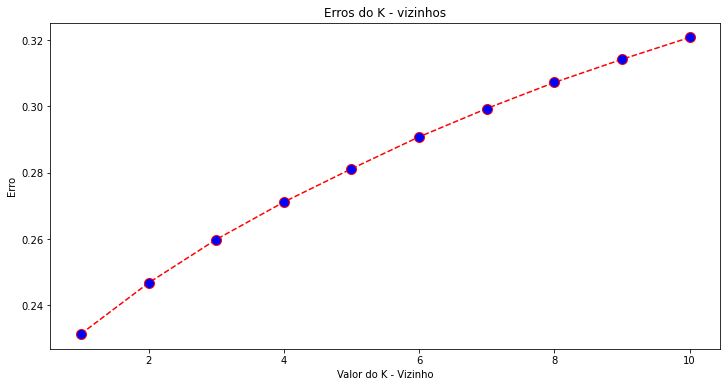

In [17]:
#Plot e caracterização do gráfico
plt.figure(figsize=(12, 6))  
# K analisados de 1 a 10.
plt.plot(range(1, 11), erro, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Erros do K - vizinhos')  
plt.xlabel('Valor do K - Vizinho')  
plt.ylabel('Erro') 

**MODELO DE PREVISÃO**

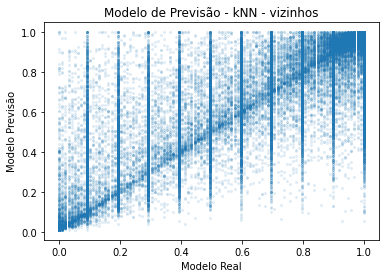

In [18]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - kNN - vizinhos")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**Comparação Baseline & K-NN**

O metódo de k-vizinhos mais próximos foi utilizado com a realização de dez k distintos que vão de um a dez. Após uma série de testes, obteve-se os seguintes resultados de RSME:

<ul>
    <li>O RMSE do modelo k-NN usando k = 1 foi de 0.08327995008962374.</li>
    <li>O RMSE do modelo k-NN usando k = 2 foi de 0.08421390750228862.</li>
    <li>O RMSE do modelo k-NN usando k = 3 foi de 0.08740112483405256.</li>
    <li>O RMSE do modelo k-NN usando k = 4 foi de 0.0907222646017814.</li>
    <li>O RMSE do modelo k-NN usando k = 5 foi de 0.09320795295367718.</li>
    <li>O RMSE do modelo k-NN usando k = 6 foi de 0.09536342936571757.</li>
    <li>O RMSE do modelo k-NN usando k = 7 foi de 0.09736359171047838.</li>
    <li>O RMSE do modelo k-NN usando k = 8 foi de 0.09917756949264539.</li>
<ul>

Nestes resultados, observou-se que o erro do modelo apresenta uma taxa de aproximadamente 0.08 - 0.10. Esse modelo ao ser comparado com o Baseline, demonstra uma maior eficiência visto que ela é uma taxa bem menor ao ser comparada com a taxa de 0.22 de erro do treino obtido com o Baseline.

<AxesSubplot: ylabel='Frequency'>

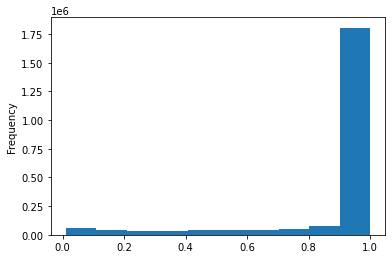

In [19]:
meses['riscofogo'].plot(kind='hist')

## 3. Modelo de Regressão Linear

In [20]:
# cria o modelo
modelo_linear = LinearRegression()

# treina o modelo
modelo_linear.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

# realiza uma previsão usando o modelo treinado
previsao = modelo_linear.predict(normalizador_x.transform(X_treino))
previsao = normalizador_y.inverse_transform(previsao)
print(previsao)

[[0.85857514]
 [0.7624289 ]
 [0.94143262]
 ...
 [0.91995971]
 [0.9593058 ]
 [0.9557734 ]]


In [21]:
y_verdadeiro = y_teste
y_previsao = modelo_linear.predict(normalizador_x.transform(X_teste))
y_previsao = normalizador_y.inverse_transform(y_previsao)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo linear foi de {RMSE}")

O RMSE do modelo linear foi de 0.20094583380310346


**MODELO DE PREVISÃO**

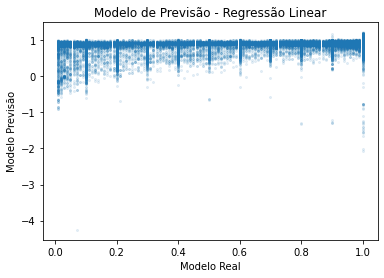

In [22]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - Regressão Linear")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**ANÁLISE DOS RESULTADOS OBTIDOS**

**Comparação Baseline & Regressão Linear**

O metódo de regressão linear, obteve como RSME:

<ul>
    <li>O RMSE do modelo linear foi de 0.20094583380310346.</li>
<ul>

Dado o resultado, observou-se que o erro do modelo apresenta uma taxa de erro de aproximadamente de 0.20. Esse modelo ao ser comparado com o Baseline, demonstra apresenta uma eficiência similar ao Baseline, devido a diferença das taxas ser de aproximadamente 0.02.

## 4. Árvore de Decisão

In [23]:
# cria o modelo
modelo_dt = DecisionTreeRegressor(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_dt.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

# realiza uma previsão usando o modelo treinado
previsao = modelo_dt.predict(X_teste)
print(previsao)

[0.6969697 0.6969697 0.6969697 ... 0.6969697 0.6969697 0.6969697]


In [24]:
y_verdadeiro = y_teste
y_previsao = modelo_dt.predict(normalizador_x.transform(X_teste))

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo de árvore de decisões foi de {RMSE}.")

O RMSE do modelo de árvore de decisões foi de 0.07898324020630844.


**HIPERPARÂMETROS - MODELO BASEADO NO MATERIAL EM SALA**

In [25]:
NUM_FOLHAS = [None, 6, 36]
NUM_PROFUNDIDADE = [None, 3, 10]

for n_folhas, n_profundidade in product(NUM_FOLHAS, NUM_PROFUNDIDADE):
    modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
    )

    modelo_dt.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(normalizador_x.transform(X_teste))

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE:.2f}."
    )

O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=None foi de 0.08.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=3 foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=10 foi de 0.13.
O RMSE do modelo AD usando max_leaf_nodes=6 e max_depth=None foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=6 e max_depth=3 foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=6 e max_depth=10 foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=36 e max_depth=None foi de 0.15.
O RMSE do modelo AD usando max_leaf_nodes=36 e max_depth=3 foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=36 e max_depth=10 foi de 0.15.


ALTERANDO OS HIPERPARÂMETROS

In [26]:
NUM_FOLHAS = [None, 4, 10]
NUM_PROFUNDIDADE = [None, 5, 10]

for n_folhas, n_profundidade in product(NUM_FOLHAS, NUM_PROFUNDIDADE):
    modelo_ad2 = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
    )

    modelo_ad2.fit(X_treino, y_treino)

    y_verdadeiro_ad2 = y_teste
    y_previsao_ad2 = modelo_ad2.predict(X_teste)
    RMSE_ad2 = mean_squared_error(y_verdadeiro_ad2, y_previsao_ad2, squared=False)

    print(
        f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE_ad2:.2f}."
    )

O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=None foi de 0.08.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=5 foi de 0.16.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=10 foi de 0.13.
O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=None foi de 0.18.
O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=5 foi de 0.18.
O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=10 foi de 0.18.
O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=None foi de 0.16.
O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=5 foi de 0.16.
O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=10 foi de 0.16.


**REPRESENTAÇÃO VISUAL DA ÁRVORE DE DECISÃO**

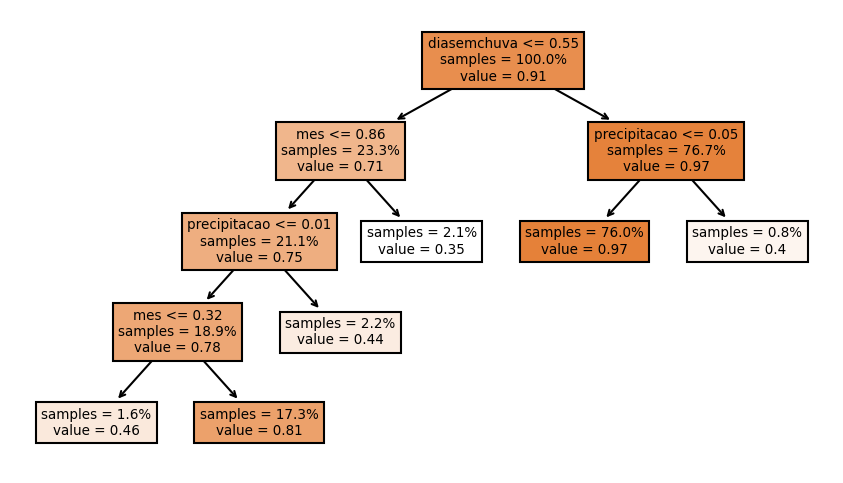

In [27]:
# cria e treina o modelo
modelo_dt = DecisionTreeRegressor(
    max_leaf_nodes=6,
    random_state=SEMENTE_ALEATORIA,
)
modelo_dt.fit(normalizador_x.transform(X_treino), normalizador_y.transform(y_treino))

# cria os objetos de figura e eixo
fig, axe = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(7, 4),
    dpi=150,
)

# plota o grafo da árvore de decisão
tree.plot_tree(
    modelo_dt,
    feature_names=FEATURES,
    ax=axe,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

# mostra o plot para o usuário
plt.show()

**MODELO DE PREVISÃO**

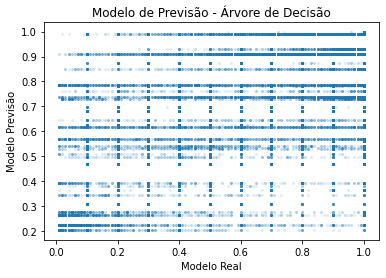

In [28]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - Árvore de Decisão")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**ANÁLISE DOS RESULTADOS OBTIDOS**

**Comparação Baseline & Árvore de Decisão**

Este modelo, usufrui da utilização de dois hiperparâmetros que foram alterados de acordo com o desejo das discentes. Dada as alterações dos hiperparâmetros, os RMSE obtidos foram de:
<ul>
    <li>O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=None foi de 0.08.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=5 foi de 0.16.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=10 foi de 0.13.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=None foi de 0.18.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=5 foi de 0.18.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=10 foi de 0.18.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=None foi de 0.16.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=5 foi de 0.16.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=10 foi de 0.16.</li>
<ul>

Estes RMSE apresentam uma grande margem de variação, visto que as taxas vão de 0.08 - 0.18. Nesse sentido observa-se que aquelas em que o max_depht são igualadas a None, os valores de erro serão menores.

## 5. Floresta aleatória

In [70]:
# alterando o formato do target
print(y_treino.shape, y_teste.shape)
y_treino = y_treino.ravel()
y_teste = y_teste.ravel()
print(y_treino.shape, y_teste.shape)

# Criação do Modelo
modelo_flore = RandomForestRegressor(random_state=SEMENTE_ALEATORIA)

normalizacao = MinMaxScaler()
X_treino_norm = normalizacao.fit_transform(X_treino)
X_teste_norm = normalizacao.transform(X_teste)
modelo_flore.fit(X_treino_norm, y_treino)

previsao = modelo_flore.predict(X_teste_norm)

print(previsao)

(2009266,) (223252,)
(2009266,) (223252,)
[1.     1.     1.     ... 0.9994 0.991  1.    ]


In [71]:
y_verdadeiro = y_teste
y_previsao = modelo_flore.predict(X_teste_norm)

RMSE_flore = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo de floresta aleatória foi de {RMSE_flore}.")

O RMSE do modelo de floresta aleatória foi de 0.060396426243068554.


**DEFINIÇÃO DE HIPERPARÂMETROS - MODELO BASEADO EM SALA**

In [72]:
NUM_ARVORES = [10, 100, 300]
NUM_FOLHAS = [None, 6]
NUM_PROFUNDIDADE = [None, 3]

for n_folhas, n_profundidade, n_arvores in product(
    NUM_FOLHAS, NUM_PROFUNDIDADE, NUM_ARVORES
):
    modelo_rf = RandomForestRegressor(
        n_estimators=n_arvores,
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
        n_jobs=4,
    )

    modelo_rf.fit(X_treino_norm, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(X_teste_norm)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo RF usando "
        f"n_estimators={n_arvores} max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE:.2f}."
    )

O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=3 foi de 0.17.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None e max_depth=3 foi de 0.17.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=None e max_depth=3 foi de 0.17.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=6 e max_depth=None foi de 0.17.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=6 e max_depth=None foi de 0.17.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=6 e max_depth=None foi de 0.17.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=6 e max_depth=3 foi de 0.17.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=6 e max_depth=3 foi de 0.17.


MODELO ALTERAÇÕES DE HIPERPARÂMETROS - 1

In [73]:
NUM_ARVORES = [10, 150, 275]
NUM_FOLHAS = [None, 8]
NUM_PROFUNDIDADE = [None, 4]

for n_folhas, n_profundidade, n_arvores in product(
    NUM_FOLHAS, NUM_PROFUNDIDADE, NUM_ARVORES
):
    modelo_rf = RandomForestRegressor(
        n_estimators=n_arvores,
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
        n_jobs=4,
    )

    modelo_rf.fit(X_treino_norm, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(X_teste_norm)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo RF usando "
        f"n_estimators={n_arvores} max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE:.2f}."
    )

O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=4 foi de 0.16.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None e max_depth=4 foi de 0.16.
O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=None e max_depth=4 foi de 0.16.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=8 e max_depth=None foi de 0.16.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=8 e max_depth=None foi de 0.16.
O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=8 e max_depth=None foi de 0.16.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=8 e max_depth=4 foi de 0.16.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=8 e max_depth=4 foi de 0.16.


**MODELO DE PREVISÃO**

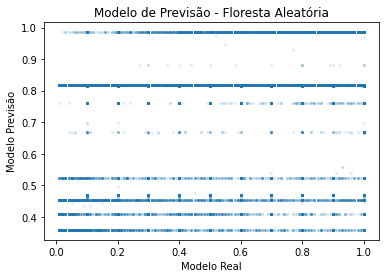

In [74]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - Floresta Aleatória")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**ANALISANDO A IMPORTÂNCIA DAS FEATURES**

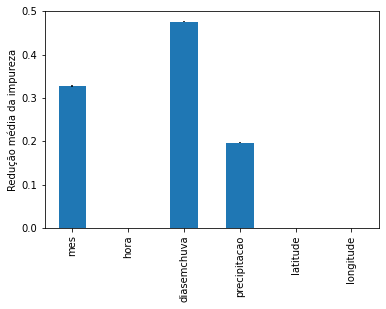

In [75]:
importancia = modelo_rf.feature_importances_
desvio_padrao = np.std(
    [arvore.feature_importances_ for arvore in modelo_rf.estimators_], axis=0
)

serie_importancia = pd.Series(importancia, index=FEATURES)

fig, axe = plt.subplots()
serie_importancia.plot.bar(yerr=desvio_padrao, ax=axe)
axe.set_ylabel("Redução média da impureza")
plt.show()

**Comparação Baseline & Floresta Aleatória**

Este modelo, usufrui da utilização de três hiperparâmetros que foram alterados de acordo com o desejo das discentes. Dada as alterações dos hiperparâmetros, os RMSE obtidos foram de:
<ul>
    <li>O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=None foi de 0.06.</li>
    <li>O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None e max_depth=None foi de 0.06.</li>
    <li>O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=None e max_depth=None foi de 0.06.</li>
    <li>O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=None e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=8 e max_depth=None foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=8 e max_depth=None foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=8 e max_depth=None foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=8 e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=8 e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=8 e max_depth=4 foi de 0.16.</li>
<ul>

Estes RMSE apresentam uma grande margem de variação, visto que as taxas vão de 0.06 - 0.16. Nesse sentido observa-se que aquelas em que o max_depht são igualadas a None, os valores de erro serão menores.

<hr>

### TREINO DE MODELOS NÃO-NORMALIZADOS

## 1. Baseline

In [29]:
# cria o modelo
modelo_baseline = DummyRegressor()
# treina o modelo
modelo_baseline.fit(X_treino, y_treino)
# realiza uma previsão usando o modelo treinado
previsao = modelo_baseline.predict(X_teste)
print(previsao)

[0.90733405 0.90733405 0.90733405 ... 0.90733405 0.90733405 0.90733405]


In [30]:
y_verdadeiro = y_teste
y_previsao = modelo_baseline.predict(X_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
print(f"O RMSE do modelo baseline foi de {RMSE}.")

O RMSE do modelo baseline foi de 0.2243682911740957.


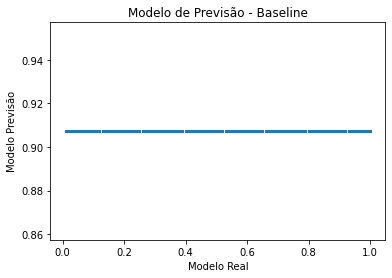

In [31]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - Baseline")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**ANÁLISE DOS RESULTADOS OBTIDOS**

Este modelo realiza a média de todos os valores normalizados do modelo, apresentando uma resolução com eficiência baixa, a qual possui 0.22 de erro de predição.

## 2. K-vizinhos mais próximos

In [32]:
# cria o modelo
modelo_knm = KNeighborsRegressor()

# treina o modelo
modelo_knm.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_knm.predict(X_treino)
print(previsao)

[[0.16]
 [0.2 ]
 [1.  ]
 ...
 [1.  ]
 [1.  ]
 [1.  ]]


**Hiperparâmetros - Analisar qual o melhor k-NN**

In [33]:
erro = []

for n in range(1, 11):
    modelo_knn = KNeighborsRegressor(n_neighbors=n)

    modelo_knn.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_knn.predict(X_teste)
    erro.append(np.mean(y_previsao != y_verdadeiro))

    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    print(f"O RMSE do modelo k-NN usando k = {n} foi de {RMSE}.")

O RMSE do modelo k-NN usando k = 1 foi de 0.08534422579596883.
O RMSE do modelo k-NN usando k = 2 foi de 0.08509752502371756.
O RMSE do modelo k-NN usando k = 3 foi de 0.08732847473520283.
O RMSE do modelo k-NN usando k = 4 foi de 0.08951491033999029.
O RMSE do modelo k-NN usando k = 5 foi de 0.09162095925925647.
O RMSE do modelo k-NN usando k = 6 foi de 0.09331903518709828.
O RMSE do modelo k-NN usando k = 7 foi de 0.09484598298155048.
O RMSE do modelo k-NN usando k = 8 foi de 0.09610478133082176.
O RMSE do modelo k-NN usando k = 9 foi de 0.09723231796906406.
O RMSE do modelo k-NN usando k = 10 foi de 0.09831063600315415.


**ANÁLISE DOS RESULTADOS OBTIDOS**

Observou-se que em números menores de vizinhos, há uma melhor predição do modelo devido a diminuição da taxa de erro. De modo a realizar esta análise por um meio visual, desenvolve-se uma representação por meio de um gráfico que demonstra a taxa de erro do treino conforme há a mudança dos vizinhos (k).

REPRESENTAÇÃO VISUAL DO MELHOR K

Text(0, 0.5, 'Erro')

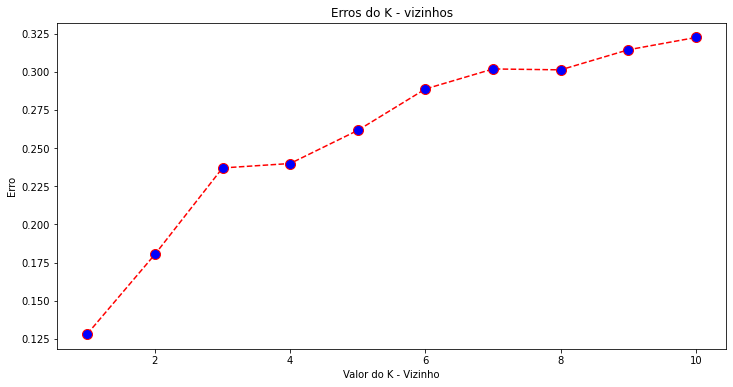

In [34]:
#Plot e caracterização do gráfico
plt.figure(figsize=(12, 6))  
# K analisados de 1 a 10.
plt.plot(range(1, 11), erro, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Erros do K - vizinhos')  
plt.xlabel('Valor do K - Vizinho')  
plt.ylabel('Erro') 

MODELO DE PREVISÃO

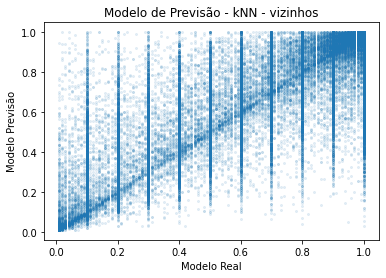

In [35]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - kNN - vizinhos")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**Comparação Baseline & K-NN**

O metódo de k-vizinhos mais próximos foi utilizado com a realização de dez k distintos que vão de um a dez. Após uma série de testes, obteve-se os seguintes resultados de RSME:

<ul>
    <li>O RMSE do modelo k-NN usando k = 1 foi de 0.08534422579596883.</li>
    <li>O RMSE do modelo k-NN usando k = 2 foi de 0.08509752502371756.</li>
    <li>O RMSE do modelo k-NN usando k = 3 foi de 0.08732847473520283.</li>
    <li>O RMSE do modelo k-NN usando k = 4 foi de 0.08951491033999029.</li>
    <li>O RMSE do modelo k-NN usando k = 5 foi de 0.09162095925925647.</li>
    <li>O RMSE do modelo k-NN usando k = 6 foi de 0.09331903518709828.</li>
    <li>O RMSE do modelo k-NN usando k = 7 foi de 0.09484598298155048.</li>
    <li>O RMSE do modelo k-NN usando k = 8 foi de 0.09610478133082176.</li>
    <li>O RMSE do modelo k-NN usando k = 9 foi de 0.09723231796906406.</li>
    <li>O RMSE do modelo k-NN usando k = 10 foi de 0.09831063600315415.</li>
<ul>    

Nestes resultados, observou-se que o erro do modelo apresenta uma taxa de aproximadamente 0.08 - 0.10. Esse modelo ao ser comparado com o Baseline, demonstra uma maior eficiência visto que ela é uma taxa bem menor ao ser comparada com a taxa de 0.22 de erro do treino obtido com o Baseline.

## 3. Modelo de Regressão Linear

In [36]:
# cria o modelo
modelo_linear = LinearRegression()

# treina o modelo
modelo_linear.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_linear.predict(X_teste)
print(previsao)

[[0.92542828]
 [0.95382171]
 [0.95293545]
 ...
 [0.89738165]
 [0.88857057]
 [0.95741038]]


In [37]:
y_verdadeiro = y_teste
y_previsao = modelo_linear.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo linear foi de {RMSE}.")

O RMSE do modelo linear foi de 0.20094583380310346.


**MODELO DE PREVISÃO**

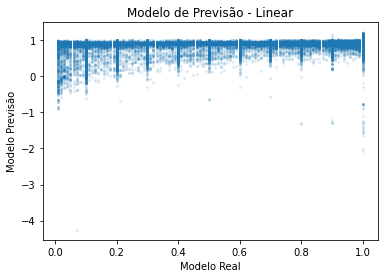

In [38]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - Linear")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**ANÁLISE DOS RESULTADOS OBTIDOS**

**Comparação Baseline & Modelo Linear**

O metódo de regressão linear, obteve como RSME:

<ul>
    <li>O RMSE do modelo linear foi de 0.20094583380310346.</li>
<ul>

Dado o resultado, observou-se que o erro do modelo apresenta uma taxa de erro de aproximadamente de 0.20. Esse modelo ao ser comparado com o Baseline, demonstra apresenta uma eficiência similar ao Baseline, devido a diferença das taxas ser de aproximadamente 0.02.

## 4. Árvore de Decisão 

In [39]:
# cria o modelo
modelo_ad = DecisionTreeRegressor(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_ad.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao_ad = modelo_ad.predict(X_teste)
print(previsao_ad)

[1. 1. 1. ... 1. 1. 1.]


In [40]:
y_verdadeiro = y_teste
y_previsao = modelo_ad.predict(X_teste)

RMSE_ad = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE_ad}.")

O RMSE do modelo árvore de decisão foi de 0.07870004976866507.


**HIPERPARÂMETROS - MODELO BASEADO NO MATERIAL EM SALA**

In [41]:
NUM_FOLHAS = [None, 6, 36]
NUM_PROFUNDIDADE = [None, 3, 10]

for n_folhas, n_profundidade in product(NUM_FOLHAS, NUM_PROFUNDIDADE):
    modelo_ad = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
    )

    modelo_ad.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_ad.predict(X_teste)
    RMSE_ad = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE_ad:.2f}."
    )

O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=None foi de 0.08.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=3 foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=10 foi de 0.13.
O RMSE do modelo AD usando max_leaf_nodes=6 e max_depth=None foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=6 e max_depth=3 foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=6 e max_depth=10 foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=36 e max_depth=None foi de 0.15.
O RMSE do modelo AD usando max_leaf_nodes=36 e max_depth=3 foi de 0.17.
O RMSE do modelo AD usando max_leaf_nodes=36 e max_depth=10 foi de 0.15.


ALTERAÇÃO DOS HIERPARÂMETROS

In [42]:
NUM_FOLHAS = [None, 4, 10]
NUM_PROFUNDIDADE = [None, 5, 10]

for n_folhas, n_profundidade in product(NUM_FOLHAS, NUM_PROFUNDIDADE):
    modelo_ad2 = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
    )

    modelo_ad2.fit(X_treino, y_treino)

    y_verdadeiro_ad2 = y_teste
    y_previsao_ad2 = modelo_ad2.predict(X_teste)
    RMSE_ad2 = mean_squared_error(y_verdadeiro_ad2, y_previsao_ad2, squared=False)

    print(
        f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE_ad2:.2f}."
    )

O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=None foi de 0.08.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=5 foi de 0.16.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=10 foi de 0.13.
O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=None foi de 0.18.
O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=5 foi de 0.18.
O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=10 foi de 0.18.
O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=None foi de 0.16.
O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=5 foi de 0.16.
O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=10 foi de 0.16.


**REPRESENTAÇÃO VISUAL DA ÁRVORE DE DECISÃO**

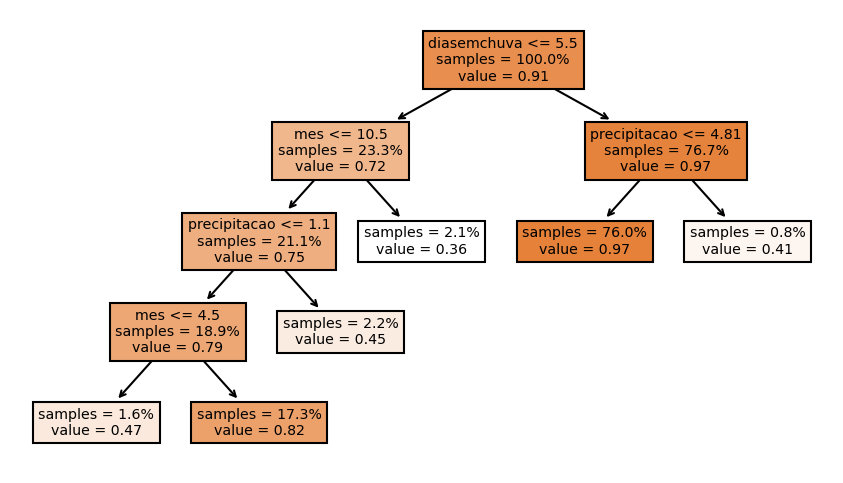

In [43]:
# cria e treina o modelo
modelo_dt = DecisionTreeRegressor(
    max_leaf_nodes=6,
    random_state=SEMENTE_ALEATORIA,
)
modelo_dt.fit(X_treino, y_treino)

# cria os objetos de figura e eixo
fig, axe = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(7, 4),
    dpi=150,
)

# plota o grafo da árvore de decisão
tree.plot_tree(
    modelo_dt,
    feature_names=FEATURES,
    ax=axe,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

# mostra o plot para o usuário
plt.show()


**MODELO DE PREVISÃO**

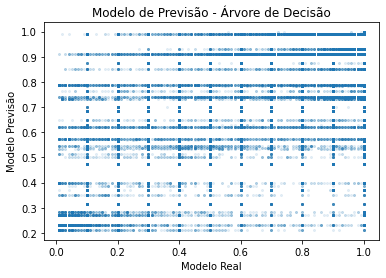

In [44]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - Árvore de Decisão")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**ANÁLISE DOS RESULTADOS OBTIDOS**

**Comparação Baseline & Árvore de Decisões**

Este modelo, usufrui da utilização de dois hiperparâmetros que foram alterados de acordo com o desejo das discentes. Dada as alterações dos hiperparâmetros, os RMSE obtidos foram de:
<ul>
    <li>O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=None foi de 0.08.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=5 foi de 0.16.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=10 foi de 0.13.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=None foi de 0.18.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=5 foi de 0.18.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=4 e max_depth=10 foi de 0.18.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=None foi de 0.16.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=5 foi de 0.16.</li>
    <li>O RMSE do modelo AD usando max_leaf_nodes=10 e max_depth=10 foi de 0.16.</li>
<ul>

Estes RMSE apresentam uma grande margem de variação, visto que as taxas vão de 0.08 - 0.18. Nesse sentido observa-se que aquelas em que o max_depht são igualadas a None, os valores de erro serão menores.

## 5. Floresta aleatória

In [63]:
# alterando o formato do target
print(y_treino.shape, y_teste.shape)
y_treino = y_treino.ravel()
y_teste = y_teste.ravel()
print(y_treino.shape, y_teste.shape)

# cria o modelo
modelo_flore2 = RandomForestRegressor(random_state=SEMENTE_ALEATORIA)

# treina o modelo
modelo_flore2.fit(X_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao_flore2 = modelo_flore2.predict(X_teste)
print()
print(previsao_flore2)

(2009266,) (223252,)
(2009266,) (223252,)

[1.     1.     1.     ... 0.9994 0.991  1.    ]


In [64]:
y_verdadeiro = y_teste
y_previsao = modelo_flore2.predict(X_teste)

RMSE_flore2 = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE_flore2}.")

O RMSE do modelo árvore de decisão foi de 0.06040035425408258.


**HIPERPARÂMETROS - MODELO BASEADO NO EM SALA**

In [66]:
NUM_ARVORES = [10, 100, 300]
NUM_FOLHAS = [None, 6]
NUM_PROFUNDIDADE = [None, 3]

for n_folhas, n_profundidade, n_arvores in product(
    NUM_FOLHAS, NUM_PROFUNDIDADE, NUM_ARVORES
):
    modelo_rf = RandomForestRegressor(
        n_estimators=n_arvores,
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
        n_jobs=4,
    )

    modelo_rf.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo RF usando "
        f"n_estimators={n_arvores} max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE:.2f}."
    )

O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=3 foi de 0.17.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=None e max_depth=3 foi de 0.17.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=None e max_depth=3 foi de 0.17.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=6 e max_depth=None foi de 0.17.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=6 e max_depth=None foi de 0.17.
O RMSE do modelo RF usando n_estimators=300 max_leaf_nodes=6 e max_depth=None foi de 0.17.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=6 e max_depth=3 foi de 0.17.
O RMSE do modelo RF usando n_estimators=100 max_leaf_nodes=6 e max_depth=3 foi de 0.17.


MODELO COM ALTERAÇÕES

In [67]:
NUM_ARVORES = [10, 150, 275]
NUM_FOLHAS = [None, 8]
NUM_PROFUNDIDADE = [None, 4]

for n_folhas, n_profundidade, n_arvores in product(
    NUM_FOLHAS, NUM_PROFUNDIDADE, NUM_ARVORES
):
    modelo_rf = RandomForestRegressor(
        n_estimators=n_arvores,
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        random_state=SEMENTE_ALEATORIA,
        n_jobs=4,
    )

    modelo_rf.fit(X_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_rf.predict(X_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
        f"O RMSE do modelo RF usando "
        f"n_estimators={n_arvores} max_leaf_nodes={n_folhas} "
        f"e max_depth={n_profundidade} foi de {RMSE:.2f}."
    )

O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=None e max_depth=None foi de 0.06.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=4 foi de 0.16.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None e max_depth=4 foi de 0.16.
O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=None e max_depth=4 foi de 0.16.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=8 e max_depth=None foi de 0.16.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=8 e max_depth=None foi de 0.16.
O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=8 e max_depth=None foi de 0.16.
O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=8 e max_depth=4 foi de 0.16.
O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=8 e max_depth=4 foi de 0.16.


**MODELO DE PREVISÃO**

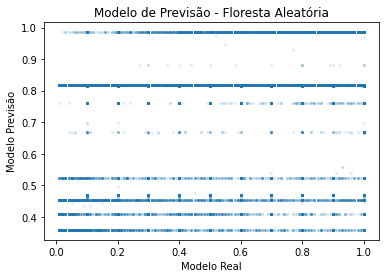

In [68]:
#Plot 
plt.plot(y_verdadeiro, y_previsao, label = 'Teste de Precisão do Dataset', ls="none", marker="o", alpha=0.1, markersize=2)
plt.title("Modelo de Previsão - Floresta Aleatória")
plt.xlabel('Modelo Real')
plt.ylabel('Modelo Previsão')
plt.show()

**ANÁLISE DA IMPORTÂNCIA DAS FEATURES**

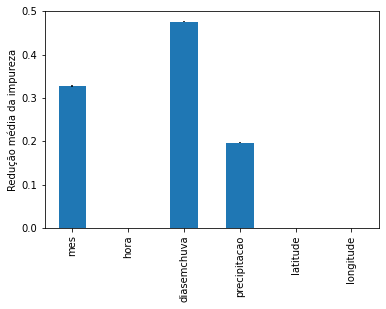

In [69]:
importancia = modelo_rf.feature_importances_
desvio_padrao = np.std(
    [arvore.feature_importances_ for arvore in modelo_rf.estimators_], axis=0
)

serie_importancia = pd.Series(importancia, index=FEATURES)

fig, axe = plt.subplots()
serie_importancia.plot.bar(yerr=desvio_padrao, ax=axe)
axe.set_ylabel("Redução média da impureza")
plt.show()

**Comparação Baseline & Floresta Aleatória**

Este modelo, usufrui da utilização de três hiperparâmetros que foram alterados de acordo com o desejo das discentes. Dada as alterações dos hiperparâmetros, os RMSE obtidos foram de:

<ul>
    <li>O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=None foi de 0.06.</li>
    <li>O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None e max_depth=None foi de 0.06.</li>
    <li>O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=None e max_depth=None foi de 0.06.</li>
    <li>O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=None e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=None e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=None e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=8 e max_depth=None foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=8 e max_depth=None foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=8 e max_depth=None foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=10 max_leaf_nodes=8 e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=150 max_leaf_nodes=8 e max_depth=4 foi de 0.16.</li>
    <li>O RMSE do modelo RF usando n_estimators=275 max_leaf_nodes=8 e max_depth=4 foi de 0.16.</li>
<ul>

Estes RMSE apresentam uma grande margem de variação, visto que as taxas vão de 0.06 - 0.16. Nesse sentido observa-se que aquelas em que o max_depht e max_leaf_nodes são igualadas a None, ao mesmo tempo, os valores de erro serão menores. Além disso, pode-se observar que, com a alteração dos hiperparâmetros, em "MODELO COM ALTERAÇÕES", todos os valores que eram de 0.17 na primeira definição dos hiperparâmetros diminuíram em 0.01.

<hr>

## Classificador

### em k-NN

In [82]:
meses = meses.reset_index()
del meses['index']
display(meses)

,mes,hora,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,Risco Categórico
0,1.0,16.0,6.0,0.00,0.70,-13.15300,-45.51600,65.1,Risco Médio-Alto
1,1.0,16.0,-999.0,0.10,0.80,-2.73600,-42.20700,15.5,Risco Alto I
2,1.0,16.0,6.0,2.10,0.90,-14.35500,-45.87300,51.0,Risco Alto II
3,1.0,16.0,7.0,0.20,0.90,-12.87100,-44.84700,30.3,Risco Alto II
4,1.0,17.0,0.0,0.20,0.20,-12.74193,-51.44371,3.6,Risco Baixo
...,...,...,...,...,...,...,...,...,...
2232513,11.0,23.0,12.0,4.65,0.91,-21.07830,-48.40050,103.5,Risco Alto III
2232514,11.0,23.0,11.0,4.06,0.98,-21.09900,-48.39570,124.2,Risco Alto III
2232515,11.0,23.0,2.0,0.40,0.04,-9.69610,-44.58670,71.7,Risco Baixo
2232516,11.0,23.0,12.0,4.65,0.91,-21.07830,-48.40050,103.1,Risco Alto III


In [83]:
meses["mes"] = meses["mes"].astype(float)
meses["hora"] = meses["hora"].astype(float)
print(meses.dtypes)

mes                 float64
hora                float64
diasemchuva         float64
precipitacao        float64
riscofogo           float64
latitude            float64
longitude           float64
frp                 float64
Risco Categórico     object
dtype: object


In [84]:
TAMANHO_TESTE = 0.1 # fração de dados utilizada para teste: 10%
SEMENTE_ALEATORIA = 61455 # semente escolhida aleatoriamente
DATASET_NAME = "meses"
FEATURES = ["mes","hora","numerodiasemchuva", "precipitacao", "latitude", "longitude"]
TARGET = ["riscofogo"]

indices = meses.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

meses_treino = meses.loc[indices_treino]
meses_teste = meses.loc[indices_teste]

X_treino = meses_treino.reindex(FEATURES, axis=1).values
y_treino = meses_treino.reindex(TARGET, axis=1).values
X_teste = meses_teste.reindex(FEATURES, axis=1).values
y_teste = meses_teste.reindex(TARGET, axis=1).values

In [85]:
# categorizando os dados
logic = meses["riscofogo"] <= 0.2
print(len(meses.loc[logic]),'Risco Baixo')
logic = (meses["riscofogo"] > 0.2) & (meses["riscofogo"] <= 0.4)
print(len(meses.loc[logic]),'Risco Baixo-Médio')
logic = (meses["riscofogo"] > 0.4) & (meses["riscofogo"] <= 0.6)
print(len(meses.loc[logic]),'Risco Médio')
logic = (meses["riscofogo"] > 0.6) & (meses["riscofogo"] <= 0.7)
print(len(meses.loc[logic]),'Risco Médio-Alto')
logic = (meses["riscofogo"] > 0.7) & (meses["riscofogo"] <= 0.8)
print(len(meses.loc[logic]),'Risco Alto I')
logic = (meses["riscofogo"] > 0.8)  & (meses["riscofogo"] <= 0.9)
print(len(meses.loc[logic]),'Risco Alto II')
logic = (meses["riscofogo"] > 0.9)
print(len(meses.loc[logic]),'Risco Alto III')

97271 Risco Baixo
69673 Risco Baixo-Médio
80350 Risco Médio
45919 Risco Médio-Alto
54212 Risco Alto I
80390 Risco Alto II
1804703 Risco Alto III


In [86]:
meses['Risco Categórico'] = None

logic = meses["riscofogo"] <= 0.2
meses.loc[logic, 'Risco Categórico'] = 'Risco Baixo'
logic = (meses["riscofogo"] > 0.2) & (meses["riscofogo"]<= 0.4)
meses.loc[logic, 'Risco Categórico'] = 'Risco Médio-Baixo'
logic = (meses["riscofogo"] > 0.4) & (meses["riscofogo"] <= 0.6)
meses.loc[logic, 'Risco Categórico'] = 'Risco Médio'
logic = (meses["riscofogo"] > 0.6) & (meses["riscofogo"] <= 0.7)
meses.loc[logic, 'Risco Categórico'] = 'Risco Médio-Alto'
logic = (meses["riscofogo"] > 0.7) & (meses["riscofogo"] <= 0.8)
meses.loc[logic, 'Risco Categórico'] = 'Risco Alto I'
logic = (meses["riscofogo"] > 0.8) & (meses["riscofogo"] <= 0.9)
meses.loc[logic, 'Risco Categórico'] ='Risco Alto II'
logic = (meses["riscofogo"] > 0.9)
meses.loc[logic, 'Risco Categórico'] = 'Risco Alto III'

print(meses)

          mes  hora  diasemchuva  precipitacao  riscofogo  latitude  \
0         1.0  16.0          6.0          0.00       0.70 -13.15300   
1         1.0  16.0       -999.0          0.10       0.80  -2.73600   
2         1.0  16.0          6.0          2.10       0.90 -14.35500   
3         1.0  16.0          7.0          0.20       0.90 -12.87100   
4         1.0  17.0          0.0          0.20       0.20 -12.74193   
...       ...   ...          ...           ...        ...       ...   
2232513  11.0  23.0         12.0          4.65       0.91 -21.07830   
2232514  11.0  23.0         11.0          4.06       0.98 -21.09900   
2232515  11.0  23.0          2.0          0.40       0.04  -9.69610   
2232516  11.0  23.0         12.0          4.65       0.91 -21.07830   
2232517  11.0  23.0         11.0          4.06       0.98 -21.09900   

         longitude    frp  Risco Categórico  
0        -45.51600   65.1  Risco Médio-Alto  
1        -42.20700   15.5      Risco Alto I  
2        

In [87]:
TAMANHO_TESTE = 0.1 # fração de dados utilizada para teste: 10%
SEMENTE_ALEATORIA = 61455 # semente escolhida aleatoriamente
DATASET_NAME = "meses"
FEATURES = ["mes","hora","diasemchuva", "precipitacao", "latitude", "longitude"]
TARGET = ["Risco Categórico"]

indices = meses.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

meses_treino = meses.loc[indices_treino]
meses_teste = meses.loc[indices_teste]

X_treino = meses_treino.reindex(FEATURES, axis=1).values
y_treino = meses_treino.reindex(TARGET, axis=1).values
X_teste = meses_teste.reindex(FEATURES, axis=1).values
y_teste = meses_teste.reindex(TARGET, axis=1).values

In [88]:
print(y_treino.shape, y_teste.shape)
y_treino = y_treino.ravel()
y_teste = y_teste.ravel()
print(y_treino.shape, y_teste.shape)

# cria o modelo
modelo_knn = KNeighborsClassifier()

# treina o modelo
modelo_knn.fit(X_treino,y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_knn.predict(X_teste)
print(previsao)

(2009266, 1) (223252, 1)
(2009266,) (223252,)
['Risco Alto III' 'Risco Alto III' 'Risco Alto III' ... 'Risco Alto III'
 'Risco Alto III' 'Risco Alto III']


In [89]:
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
y_pred = modelo_knn.predict(X_teste)
confusion_matrix(y_teste,y_pred)
pd.crosstab(y_teste, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Risco Alto I,Risco Alto II,Risco Alto III,Risco Baixo,Risco Médio,Risco Médio-Alto,Risco Médio-Baixo,All
True,,,,,,,,
Risco Alto I,2148,707,1378,174,435,379,151,5372
Risco Alto II,782,3409,3108,150,301,196,122,8068
Risco Alto III,994,1802,176258,337,619,282,266,180558
Risco Baixo,153,132,526,7576,329,64,688,9468
Risco Médio,526,307,1112,621,4339,403,731,8039
Risco Médio-Alto,591,353,886,216,771,1637,202,4656
Risco Médio-Baixo,242,203,650,1251,945,159,3641,7091
All,5436,6913,183918,10325,7739,3120,5801,223252


Text(0.5, 15.0, 'Predicted label')

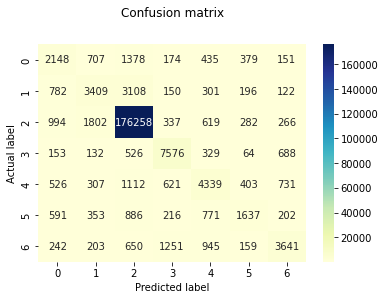

In [90]:
#let us get the predictions using the classifier we had fit above
y_pred = modelo_knn.predict(X_teste)
confusion_matrix(y_teste,y_pred)
pd.crosstab(y_teste, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

y_pred = modelo_knn.predict(X_teste)
c_matrix = confusion_matrix(y_teste, y_pred)
p = sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [91]:
print(classification_report(y_teste,y_pred))

                   precision    recall  f1-score   support

     Risco Alto I       0.40      0.40      0.40      5372
    Risco Alto II       0.49      0.42      0.46      8068
   Risco Alto III       0.96      0.98      0.97    180558
      Risco Baixo       0.73      0.80      0.77      9468
      Risco Médio       0.56      0.54      0.55      8039
 Risco Médio-Alto       0.52      0.35      0.42      4656
Risco Médio-Baixo       0.63      0.51      0.56      7091

         accuracy                           0.89    223252
        macro avg       0.61      0.57      0.59    223252
     weighted avg       0.88      0.89      0.89    223252



In [92]:
accuracy_score(y_teste, y_pred)

0.891405228172648

## Comparando os desempenhos dos modelos de regressão

Para comparar os cinco modelos preditivos desenvolvidos, comparamos os valores de RMSE e de precisão, a fim de determinar qual deles possuia o melhor desempenho. Para tanto, nós colocamos esses valores em uma tabela, e obtemos o seguinte resultado:

Modelo | Normalizado | Não Normalizado
-------|-------------|-----------------
Baseline| 0.22437296 | 0.22436829
1 k-NN | 0.08327995 | 0.08534422
2 k-NN | 0.08421390 | 0.08509752
3 k-NN | 0.08740112 | 0.08732847
4 k-NN | 0.09072226 | 0.08951491
5 k-NN | 0.09320795 | 0.09162095
6 k-NN | 0.09536342 | 0.09331903
7 k-NN | 0.09736359 | 0.09484598
8 k-NN | 0.09917756 | 0.09610478
Regressão| 0.20094583 | 0.20094583
Árvore | 0.07898324 | 0.07870004
Floresta | 0.06039642 | 0.06040035

Podemos perceber, pois, que tanto para o s dados normalizados quanto para os dados não normalizados, os melhores modelos preditivos (isto é, os que resultam em melhor previsão) são os de FLoresta aleatória e o de K-NN. Direcionando nosso olhar para o K-NN, podemos perceber, também, que os melhores resultados desse modelo são obtidos com menores números de vizinhos selecionados. Isso ocorre pois, no caso dos nossos dados, quando realizamos o modelo K-NN com uma grande quantidade de vizinhos, nós estamos nos "afastando" muito da área que está sendo utilizada para predição, o que torna as previsões menos precisas. O gráfico presente na seção "K-NN vizinhos" mostra exatamente como o erro desse modelo cresce conforme aumentamos o número de vizinhos analisados:

Text(0, 0.5, 'Erro')

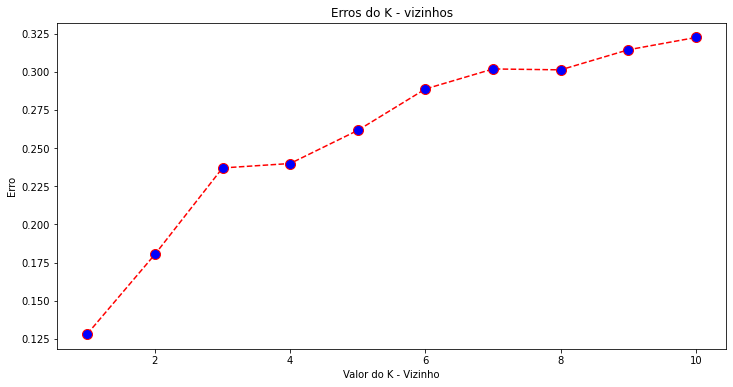

In [93]:
#Plot e caracterização do gráfico
plt.figure(figsize=(12, 6))  
# K analisados de 1 a 10.
plt.plot(range(1, 11), erro, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Erros do K - vizinhos')  
plt.xlabel('Valor do K - Vizinho')  
plt.ylabel('Erro') 